In [1]:
import pandas as pd
import numpy as np
import os
path_in = os.path.join("../Data")  # parent directory
np.random.seed(42)

import sys
sys.path.append(os.path.abspath(".."))  

from FinalToolModels.models import *
from FinalToolModels.simulate import *
from FinalToolModels.plot import *
from FinalToolModels.train import *
from FinalToolModels.split_dataset import *

%load_ext autoreload
%autoreload 2

# === Paths ===
###################### ======================== Case Study 2 ======================= ###########################

file_path = os.path.join(path_in, "dataset4.xlsx")
cs2 = pd.read_excel(file_path)
# Rename columns
rename_mapping = {
        'T_ext': 'OUTDOOR_TEMP',
        'heating_total [kW]': 'PHI_H',
        'GHI': 'PYRANOMETER',
        'T_int': 'INDOOR_TEMP'
    }
cs2 = cs2.rename(columns=rename_mapping)
cs2['PHI_H']=cs2['PHI_H']*1000
# Convert 't' to datetime and set as index

cs2['Time'] = pd.to_datetime(cs2['Time'])
cs2 = cs2.set_index('Time')
cs2 = cs2.resample("30min").mean()
cs2_surface_area = 2100  # m² 
cs2_dataset1 = cs2.iloc[0:960]
cs2_dataset2 = cs2.iloc[960:1920]
cs2_dataset3 = cs2.iloc[1920:2880]

train_cs2, val_cs2_dataset1, test_cs2 = split_dataset(cs2_dataset1, testing_days=0, val_split=1.0)
train_cs2, val_cs2_dataset2, test_cs2 = split_dataset(cs2_dataset2, testing_days=0, val_split=1.0)
train_cs2, val_cs2_dataset3, test_cs2 = split_dataset(cs2_dataset3, testing_days=0, val_split=1.0)

# split_index = int(1 * len(cs2))
# end_index = int(len(cs2)) 
# train_cs2 = cs2.iloc[:split_index]
# val_cs2 = cs2.iloc[split_index:end_index]


In [2]:
#### Function

def run_case_study(train_df,val_df, surface_area, model_type, label, bounds, trials):
    
    model, parameters, initialization, all_trials = train_greybox_model(
        train_df=train_df,
        model_type=model_type,
        bounds=bounds,
        solver_name="ipopt",
        num_trials=trials,
        deltaT=1800,
        show_plot=False
    )

    best_obj = all_trials['Objective'].min()
    mean_obj = all_trials["Objective"].mean()
    std_obj = all_trials["Objective"].std()
    matches = (np.round(all_trials['Objective'], 5) == np.round(best_obj, 5))
    n_matches = matches.sum()
    n_total = len(all_trials)
    success_rate = 100 * n_matches / n_total

    print(f"[{label}] Best Objective achieved in {n_matches} out of {n_total} trials.")
    print(f"[{label}] Success rate: {success_rate:.2f}%")
    print(f"[{label}] Best Objective was equal to {best_obj}")
    print(f"[{label}] Mean RMSE: {mean_obj:.2f}")
    print(f"[{label}] RMSE Std. Dev.: {std_obj:.2f}")
    print("\n")
    return model, all_trials

## 1R1C

In [ ]:

bounds_cs2 = {
        "R_in_a": (0.0001, 1),
        "C_in": (1e6, 1e10),
        "Ain": (0.001, 0.3 * cs2_surface_area)
    }
model_1r1c_cs2, all_trials_1r1c_cs2 = run_case_study(train_df=val_cs2_dataset1, val_df=test_cs2, surface_area=cs2_surface_area, model_type="1R1C",  label="Case Study 2",bounds=bounds_cs2, trials=10)
model_1r1c_cs2, all_trials_1r1c_cs2 = run_case_study(train_df=val_cs2_dataset2, val_df=test_cs2, surface_area=cs2_surface_area, model_type="1R1C",  label="Case Study 2",bounds=bounds_cs2, trials=10)
model_1r1c_cs2, all_trials_1r1c_cs2 = run_case_study(train_df=val_cs2_dataset3, val_df=test_cs2, surface_area=cs2_surface_area, model_type="1R1C",  label="Case Study 2",bounds=bounds_cs2, trials=10)


[Trial 1] RMSE = 0.7161, Init: {'R_in_a': 0.11968228651370788, 'C_in': 7132734627.442727, 'Ain': 479.29481984359677}
 parameters: {'R_in_a': 0.0005459149882860191, 'C_in': 2440310178.4869256, 'Ain': 255.79662812200328, 'fh': 1, 'Objective': 0.5127859142358271, 'Solve_time': 0.03526496887207031}
[Trial 2] RMSE = 0.7161, Init: {'R_in_a': 0.5613210698497393, 'C_in': 7709900832.365655, 'Ain': 311.0917319139698}
 parameters: {'R_in_a': 0.0005459149882860145, 'C_in': 2440310178.4869547, 'Ain': 255.79662812201227, 'fh': 1, 'Objective': 0.5127859142358299, 'Solve_time': 0.040846824645996094}
[Trial 3] RMSE = 0.7161, Init: {'R_in_a': 0.5227805560990558, 'C_in': 4275982642.5671377, 'Ain': 16.015024429653227}
 parameters: {'R_in_a': 0.0005459149882860151, 'C_in': 2440310178.4869537, 'Ain': 255.79662812201107, 'fh': 1, 'Objective': 0.5127859142358315, 'Solve_time': 0.03605484962463379}
[Trial 4] RMSE = 0.7161, Init: {'R_in_a': 0.10798063785060512, 'C_in': 315260427.68165576, 'Ain': 400.93892268577

# 2R2C

In [5]:
# --- Bounds ---

bounds_cs2 = {
    "R_e_a": (0.0005, 1),
    "R_in_e": (0.0005, 1),
    "C_in": (1e6, 1e10),
    "C_e": (1e6, 1e10),
    "Ain": (0.001, 0.3 * cs2_surface_area),
    "Ae": (0.001, 0.3 * cs2_surface_area),
    "fh": (0,1)
}

model_2r2c_cs2, all_trials_2r2c_cs2 = run_case_study(train_df=val_cs2_dataset1, val_df=test_cs2, surface_area=cs2_surface_area, label="Case Study 2",model_type="2R2C_A", bounds=bounds_cs2, trials=10)
model_2r2c_cs2, all_trials_2r2c_cs2 = run_case_study(train_df=val_cs2_dataset2, val_df=test_cs2, surface_area=cs2_surface_area, label="Case Study 2",model_type="2R2C_A", bounds=bounds_cs2, trials=10)
model_2r2c_cs2, all_trials_2r2c_cs2 = run_case_study(train_df=val_cs2_dataset3, val_df=test_cs2, surface_area=cs2_surface_area, label="Case Study 2",model_type="2R2C_A", bounds=bounds_cs2, trials=10)


[Trial 1] RMSE = 0.7143, Init: {'R_e_a': 0.3413958178747334, 'R_in_e': 0.11391678447996878, 'C_in': 9247011489.167349, 'C_e': 8773516194.456429, 'Ain': 162.50396751892032, 'Ae': 415.79028901748677, 'fh': 0.8172222002012158}
 parameters: {'R_in_e': 0.0004999902568267885, 'R_e_a': 0.000499990111383233, 'C_in': 1298586942.7507756, 'C_e': 3432533.266656783, 'Ain': 144.3112744126208, 'Ae': 0.0011128117254757498, 'fh': 0.07983377044171829, 'Objective': 0.5102860268955008, 'Solve_time': 0.3687911033630371}
[Trial 2] RMSE = 0.8797, Init: {'R_e_a': 0.5554232111936626, 'R_in_e': 0.5298857530668285, 'C_in': 2419281056.7136164, 'C_e': 931934575.2911862, 'Ain': 565.2460302948379, 'Ae': 567.263475594841, 'fh': 0.6331014572732679}
 parameters: {'R_in_e': 0.014454778580686441, 'R_e_a': 0.0005798540672018351, 'C_in': 75794354.33723427, 'C_e': 4213478955.019594, 'Ain': 7.280391601771118, 'Ae': 0.001238505573332842, 'fh': -6.516680066689751e-09, 'Objective': 0.7738401142850461, 'Solve_time': 0.2547800540

[Trial 1] RMSE = 0.2118, Init: {'R_in_e': 0.10402074496709668, 'R_e_a': 0.902650353772887, 'R_in_a': 0.5057471200754093, 'C_in': 413402275.5877631, 'C_e': 160704750.91427526, 'Ain': 26.865707302563166, 'Ae': 11.676111441857019, 'fh': 0.01083765148029836}
 parameters: {'R_in_e': 0.004630202170027869, 'R_e_a': 0.03446370451234192, 'R_in_a': 0.023420287391484537, 'C_in': 13160527.259009544, 'C_e': 10013348.962171808, 'Ain': 1.1138786734134327, 'Ae': 0.00010022211366422331, 'fh': 0.6222077532578979, 'Objective': 0.04484509183054725, 'Solve_time': 1.4634137153625488}
[Trial 2] RMSE = 0.6313, Init: {'R_in_e': 0.9054765944428443, 'R_e_a': 0.09219539010934742, 'R_in_a': 0.31999432395282446, 'C_in': 475080921.55835164, 'C_e': 475352966.3218405, 'Ain': 17.20317929990977, 'Ae': 18.95515318137276, 'fh': 0.44844552197831977}
 parameters: {'R_in_e': 0.023891537874457504, 'R_e_a': 0.0010550380775111124, 'R_in_a': 0.0088407508946634, 'C_in': 440878180.903652, 'C_e': 469047098.3014314, 'Ain': 29.999998

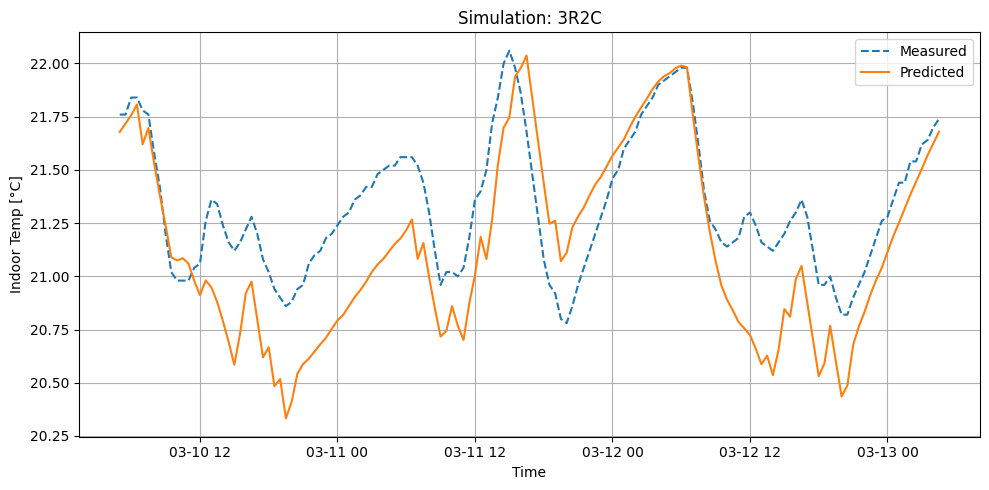

[Case Study 1] Training RMSE: 0.16002134907269924
Validation RMSE: 0.3157


[Trial 1] RMSE = 0.5327, Init: {'R_in_e': 0.6297692394971273, 'R_e_a': 0.6960529402956326, 'R_in_a': 0.45508652370300545, 'C_in': 314151481.9619477, 'C_e': 292572841.64962703, 'Ain': 567.729556493522, 'Ae': 28.631315070480426, 'fh': 0.2809631895922303}
 parameters: {'R_in_e': 0.003093117344101867, 'R_e_a': 0.0016402482254484867, 'R_in_a': 0.0013892641030428155, 'C_in': 499999739.29813826, 'C_e': 499999969.3373964, 'Ain': 149.6849769806658, 'Ae': 0.00013654990437807752, 'fh': 0.1550658791897432, 'Objective': 0.28375929619972384, 'Solve_time': 0.39949679374694824}
[Trial 2] RMSE = 0.5327, Init: {'R_in_e': 0.9504610725924821, 'R_e_a': 0.8903735201070254, 'R_in_a': 0.45620109603292724, 'C_in': 310446166.30296683, 'C_e': 139413210.3075852, 'Ain': 118.51641181385367, 'Ae': 292.13004874234827, 'fh': 0.3533522280260528}
 parameters: {'R_in_e': 0.0030931173441018627, 'R_e_a': 0.0016402482254484821, 'R_in_a': 0.001389264

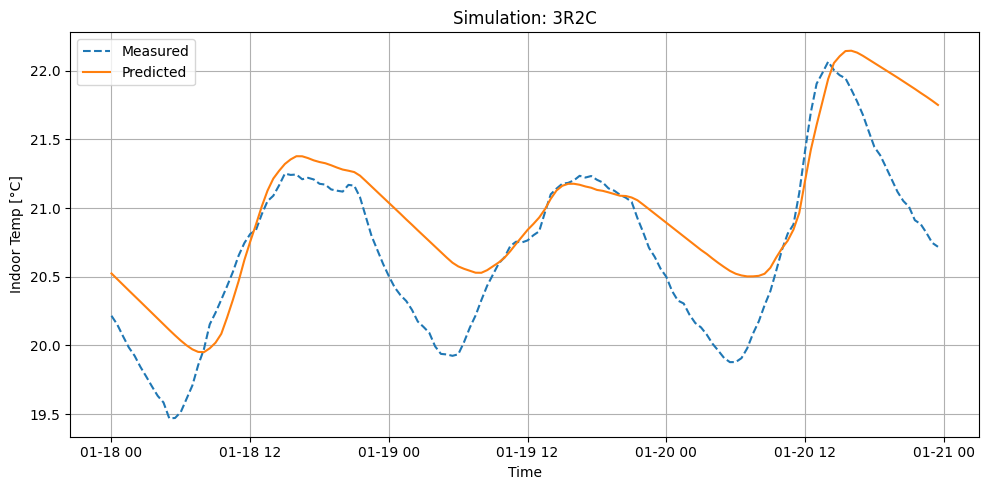

[Case Study 2] Training RMSE: 0.5326906195822636
Validation RMSE: 0.4282


[Trial 1] RMSE = 0.9908, Init: {'R_in_e': 0.7043756883311243, 'R_e_a': 0.21375119734740183, 'R_in_a': 0.137235104111183, 'C_in': 8257788.168273082, 'C_e': 175943191.8444919, 'Ain': 10.08763345344554, 'Ae': 6.707433946800911, 'fh': 0.43747492202372906}
 parameters: {'R_in_e': 0.0009999900025906715, 'R_e_a': 0.9999624328936964, 'R_in_a': 0.0047070807141840094, 'C_in': 1000000.0024629452, 'C_e': 313270860.8788058, 'Ain': 0.00010001807921233251, 'Ae': 10.315512233807413, 'fh': 0.7279937161700556, 'Objective': 0.9816263801800914, 'Solve_time': 1.2895240783691406}
[Trial 2] RMSE = 1.0905, Init: {'R_in_e': 0.9042545357992546, 'R_e_a': 0.3489072115562771, 'R_in_a': 0.514475499670651, 'C_in': 392042853.3578304, 'C_e': 198874848.3783138, 'Ain': 10.637720365226613, 'Ae': 14.746433183198466, 'fh': 0.9495206236576421}
 parameters: {'R_in_e': 0.0020523423868931715, 'R_e_a': 0.9991931384673425, 'R_in_a': 0.002142905767628529, 

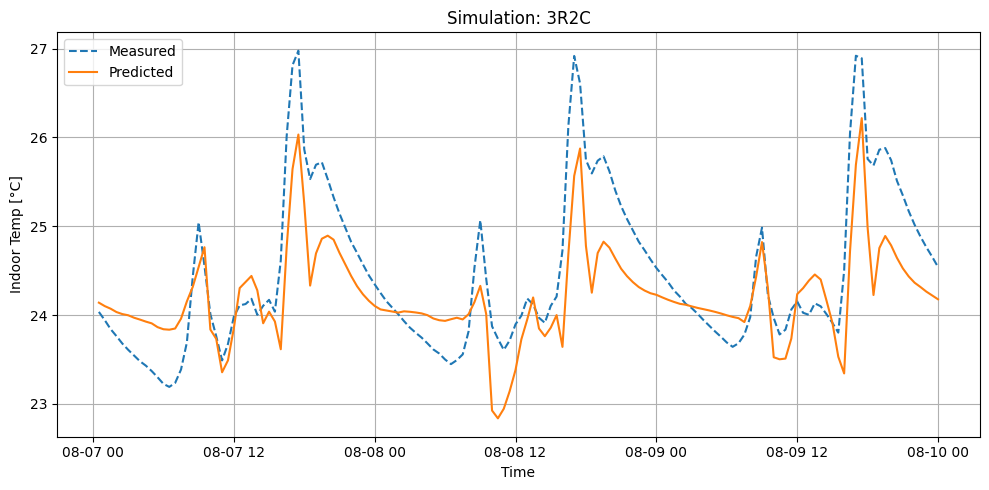

[Case Study 3] Training RMSE: 0.6829497224365184
Validation RMSE: 0.5826


[Trial 1] RMSE = 0.7625, Init: {'R_in_e': 0.021051126579948645, 'R_e_a': 0.3227570864175951, 'R_in_a': 0.2122365589895481, 'C_in': 164421178.73677942, 'C_e': 60761303.77780636, 'Ain': 15.228027447924127, 'Ae': 10.150471596528876, 'fh': 0.6791023191444896}
 parameters: {'R_in_e': 0.0009999900107383712, 'R_e_a': 0.9999943418831475, 'R_in_a': 0.006567660224666345, 'C_in': 1000000.0085238204, 'C_e': 114326855.79268731, 'Ain': 0.29575744210499877, 'Ae': 7.1583049900638045, 'fh': 0.06729357533413816, 'Objective': 0.5814654574700108, 'Solve_time': 0.6715190410614014}
[Trial 2] RMSE = 0.7896, Init: {'R_in_e': 0.789382067368731, 'R_e_a': 0.4989437567301282, 'R_in_a': 0.08783336779933627, 'C_in': 269016164.36745536, 'C_e': 293833717.8924187, 'Ain': 12.747040464604623, 'Ae': 7.381435074572893, 'fh': 0.12758030279556376}
 parameters: {'R_in_e': 0.0009999900264878053, 'R_e_a': 0.01999583320806602, 'R_in_a': 0.000999990041011

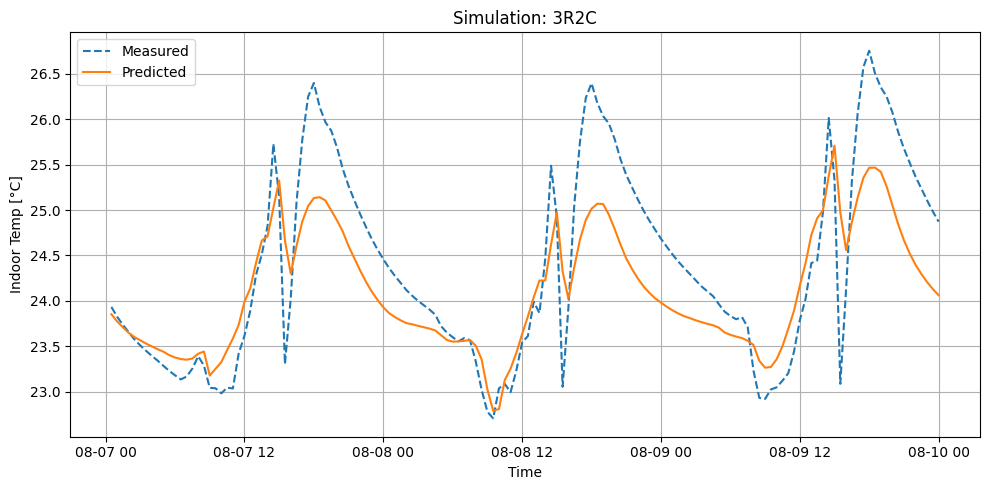

[Case Study 4] Training RMSE: 0.472725690163785
Validation RMSE: 0.6294




In [6]:
# --- Bounds ---
bounds_cs1 = {
    "R_in_e": (0.001, 1),
    "R_e_a": (0.001, 1),
    "R_in_a": (0.001, 1),
    "C_in": (1e6, 5e8),
    "C_e": (1e6, 5e8),
    "Ain": (0.0001, 0.3 * cs1_surface_area),
    "Ae": (0.0001, 0.3 * cs1_surface_area),
    "fh": (0,1)
}
bounds_cs2 = {
    "R_in_e": (0.001, 1),
    "R_e_a": (0.001, 1),
    "R_in_a": (0.001, 1),
    "C_in": (1e6, 5e8),
    "C_e": (1e6, 5e8),
    "Ain": (0.0001, 0.3 * cs2_surface_area),
    "Ae": (0.0001, 0.3 * cs2_surface_area),
    "fh": (0,1)
}
bounds_cs3 = {
    "R_in_e": (0.001, 1),
    "R_e_a": (0.001, 1),
    "R_in_a": (0.001, 1),
    "C_in": (1e6, 5e8),
    "C_e": (1e6, 5e8),
    "Ain": (0.0001, 0.3 * cs3_surface_area),
    "Ae": (0.0001, 0.3 * cs3_surface_area),
    "fh": (0,1)
}
bounds_cs4 = {
    "R_in_e": (0.001, 1),
    "R_e_a": (0.001, 1),
    "R_in_a": (0.001, 1),
    "C_in": (1e6, 5e8),
    "C_e": (1e6, 5e8),
    "Ain": (0.0001, 0.3 * cs4_surface_area),
    "Ae": (0.0001, 0.3 * cs4_surface_area),
    "fh": (0,1)
}


# model_3r2c_cs1, val_pred_3r2c_cs1, test_pred_3r2c_cs1 = run_case_study(train_df=train_cs1, val_df=val_cs1, test_df=test_cs1, surface_area=cs1_surface_area, label="Case Study 1",model_type="3R2C", bounds=bounds_cs1, trials=5)
# model_3r2c_cs2, val_pred_3r2c_cs2, test_pred_3r2c_cs2 = run_case_study(train_df=train_cs2, val_df=val_cs1, test_df=test_cs1, surface_area=cs2_surface_area, label="Case Study 2",model_type="3R2C", bounds=bounds_cs2, trials=5)
# model_3r2c_cs3, val_pred_3r2c_cs3, test_pred_3r2c_cs3 = run_case_study(train_df=train_cs3, val_df=val_cs1, test_df=test_cs1, surface_area=cs3_surface_area, label="Case Study 3",model_type="3R2C", bounds=bounds_cs3, trials=5)
# model_3r2c_cs4, val_pred_3r2c_cs4, test_pred_3r2c_cs4 = run_case_study(train_df=train_cs4, val_df=val_cs1, test_df=test_cs1, surface_area=cs4_surface_area, label="Case Study 4",model_type="3R2C", bounds=bounds_cs4, trials=5)


model_3r2c_cs1, val_pred_3r2c_cs1, solve_time_3r2c_cs1 = run_case_study(train_df=val_cs1, val_df=test_cs1, surface_area=cs1_surface_area, label="Case Study 1",model_type="3R2C", bounds=bounds_cs1, trials=10)
model_3r2c_cs2, val_pred_3r2c_cs2, solve_time_3r2c_cs2 = run_case_study(train_df=val_cs2, val_df=test_cs2, surface_area=cs2_surface_area, label="Case Study 2",model_type="3R2C", bounds=bounds_cs2, trials=10)
model_3r2c_cs3, val_pred_3r2c_cs3, solve_time_3r2c_cs3 = run_case_study(train_df=val_cs3, val_df=test_cs3, surface_area=cs3_surface_area, label="Case Study 3",model_type="3R2C", bounds=bounds_cs3, trials=10)
model_3r2c_cs4, val_pred_3r2c_cs4, solve_time_3r2c_cs4 = run_case_study(train_df=val_cs4, val_df=test_cs4, surface_area=cs4_surface_area, label="Case Study 4",model_type="3R2C", bounds=bounds_cs4, trials=10)


In [7]:
# --- Bounds ---

bounds_cs2 = {
    "R_int_in": (0.002, 1),
    "R_in_e": (0.002, 1),
    "R_e_a": (0.002, 1),
    "R_in_a": (0.002, 1),
    "C_int": (1.2e6, 5e8),
    "C_in": (1.2e6, 5e8),
    "C_e": (1.2e6, 5e8),
    "Aint": (0.0001, 0.3 * cs2_surface_area),
    "Ain": (0.0001, 0.3 * cs2_surface_area),
    "Ae": (0.0001, 0.3 * cs2_surface_area),
    "fh_int": (0,1),
    "fh_in": (0,1),
    "fh_e": (0,1)
}

model_4r3c_cs2, solve_time_4r3c_cs2 = run_case_study(train_df=val_cs2_dataset1, val_df=test_cs2, surface_area=cs2_surface_area, label="Case Study 2",model_type="4R3C", bounds=bounds_cs2, trials=10)
model_4r3c_cs2, solve_time_4r3c_cs2 = run_case_study(train_df=val_cs2_dataset2, val_df=test_cs2, surface_area=cs2_surface_area, label="Case Study 2",model_type="4R3C", bounds=bounds_cs2, trials=10)
model_4r3c_cs2, solve_time_4r3c_cs2 = run_case_study(train_df=val_cs2_dataset3, val_df=test_cs2, surface_area=cs2_surface_area, label="Case Study 2",model_type="4R3C", bounds=bounds_cs2, trials=10)


[Trial 1] RMSE = 0.5976, Init: {'R_int_in': 0.990524131716672, 'R_in_e': 0.41379244155760364, 'R_e_a': 0.3732740496211976, 'R_in_a': 0.7768601348205129, 'C_int': 171192805.8782053, 'C_in': 465461754.0110581, 'C_e': 429376280.6192943, 'Aint': 270.2662943468588, 'Ain': 473.04879762153655, 'Ae': 475.3620352190625, 'fh_int': 0.10312386883593261, 'fh_in': 0.9025529066795667, 'fh_e': 0.5052523724478571}
 parameters: {'R_int_in': 0.0041317645777648486, 'R_in_e': 0.999995321133857, 'R_e_a': 0.001999991154185005, 'R_in_a': 0.002050779013161828, 'C_int': 172254261.99473014, 'C_in': 467744681.6963809, 'C_e': 432001458.27677, 'Aint': 0.00010245359031834572, 'Ain': 106.10434415599306, 'Ae': 0.00036693175980525205, 'fh_int': 0.06983850334217019, 'fh_in': 0.10497113023272507, 'fh_e': 0.8251903664251047, 'Objective': 0.35707288225972833, 'Solve_time': 0.8766381740570068}
[Trial 2] RMSE = 0.5424, Init: {'R_int_in': 0.8268045511755261, 'R_in_e': 0.32140950182855055, 'R_e_a': 0.8957321820392081, 'R_in_a'

RMSE 1R1C Case Study 1: 0.23 °C
RMSE 2R2C Case Study 1: 0.21 °C
RMSE 3R2C Case Study 1: 0.16 °C
RMSE 4R3C Case Study 1: 0.12 °C
RMSE 1R1C Case Study 2: 0.73 °C
RMSE 2R2C Case Study 2: 0.84 °C
RMSE 3R2C Case Study 2: 0.53 °C
RMSE 4R3C Case Study 2: 0.51 °C
RMSE 1R1C Case Study 3: 1.14 °C
RMSE 2R2C Case Study 3: 0.79 °C
RMSE 3R2C Case Study 3: 0.68 °C
RMSE 4R3C Case Study 3: 0.64 °C
RMSE 1R1C Case Study 4: 0.78 °C
RMSE 2R2C Case Study 4: 0.51 °C
RMSE 3R2C Case Study 4: 0.47 °C
RMSE 4R3C Case Study 4: 0.47 °C


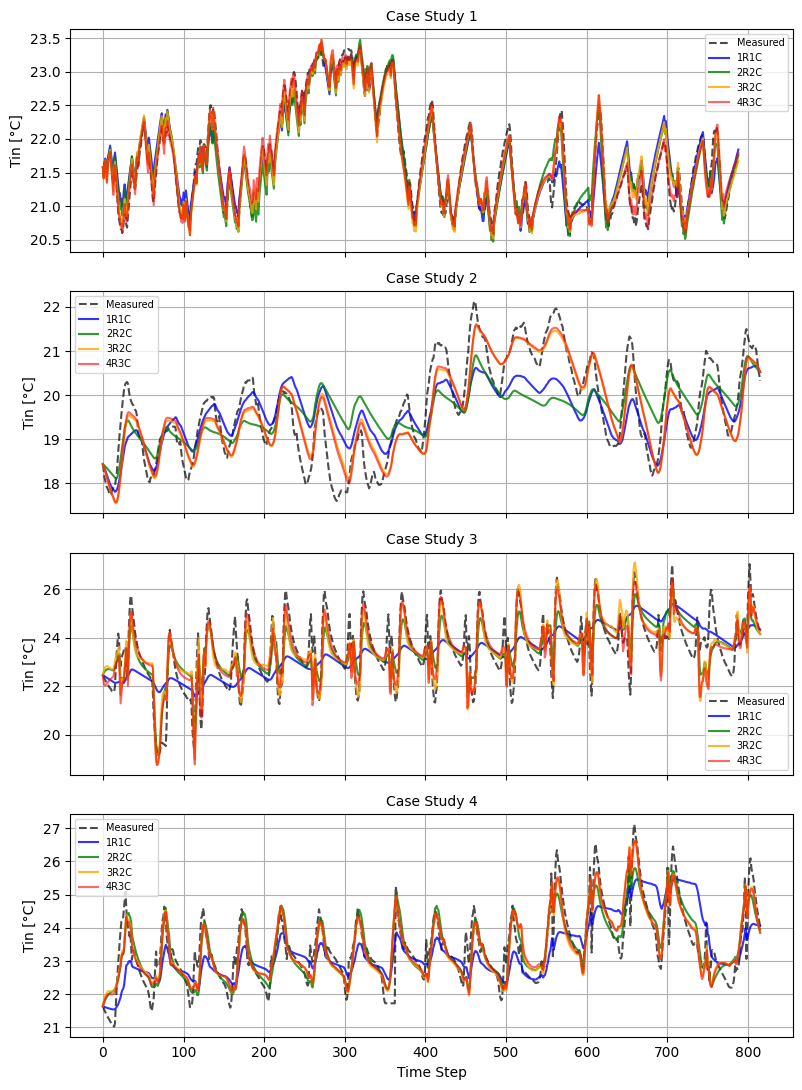

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# === Prepare data ===
datasets = [val_cs1, val_cs2, val_cs3, val_cs4]
labels = ['Case Study 1', 'Case Study 2', 'Case Study 3', 'Case Study 4']
colors = ['blue', 'green', 'orange', 'red']
model_sets = [
    [model_1r1c_cs1, model_2r2c_cs1, model_3r2c_cs1, model_4r3c_cs1],
    [model_1r1c_cs2, model_2r2c_cs2, model_3r2c_cs2, model_4r3c_cs2],
    [model_1r1c_cs3, model_2r2c_cs3, model_3r2c_cs3, model_4r3c_cs3],
    [model_1r1c_cs4, model_2r2c_cs4, model_3r2c_cs4, model_4r3c_cs4],
]
model_names = ['1R1C', '2R2C', '3R2C', '4R3C']

# === Create subplots ===
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8, 11), sharex=True)

for i, (ax, df, models, label) in enumerate(zip(axes, datasets, model_sets, labels)):
    N = len(df)
    x = np.arange(N)
    T_true = df["INDOOR_TEMP"].values[:N]

    ax.plot(x, T_true, linestyle='--', color='black', alpha=0.7, label='Measured')

    for model, color, name in zip(models, colors, model_names):
        if color=='red':
            T_model = np.array([model.T_in[t]() for t in model.T_in.index_set()])
            ax.plot(x, T_model[:N], label=name, color=color, alpha=0.6)
        else:
            T_model = np.array([model.T_in[t]() for t in model.T_in.index_set()])
            ax.plot(x, T_model[:N], label=name, color=color, alpha=0.8)
        print(f"RMSE {name} {label}: {np.sqrt(mean_squared_error(df['INDOOR_TEMP'], T_model[:N])):.2f} °C")
    ax.set_ylabel("Tin [°C]")
    ax.set_title(label, fontsize=10)
    ax.grid(True)
    ax.legend(fontsize=7)

axes[-1].set_xlabel("Time Step")
plt.tight_layout()
plt.show()


RMSE 1R1C Case Study 1: 0.30 °C
RMSE 2R2C Case Study 1: 0.28 °C
RMSE 3R2C Case Study 1: 0.32 °C
RMSE 4R3C Case Study 1: 0.25 °C
RMSE 1R1C Case Study 2: 0.39 °C
RMSE 2R2C Case Study 2: 0.39 °C
RMSE 3R2C Case Study 2: 0.43 °C
RMSE 4R3C Case Study 2: 0.39 °C
RMSE 1R1C Case Study 3: 0.70 °C
RMSE 2R2C Case Study 3: 0.59 °C
RMSE 3R2C Case Study 3: 0.58 °C
RMSE 4R3C Case Study 3: 0.48 °C
RMSE 1R1C Case Study 4: 0.89 °C
RMSE 2R2C Case Study 4: 0.63 °C
RMSE 3R2C Case Study 4: 0.63 °C
RMSE 4R3C Case Study 4: 0.68 °C


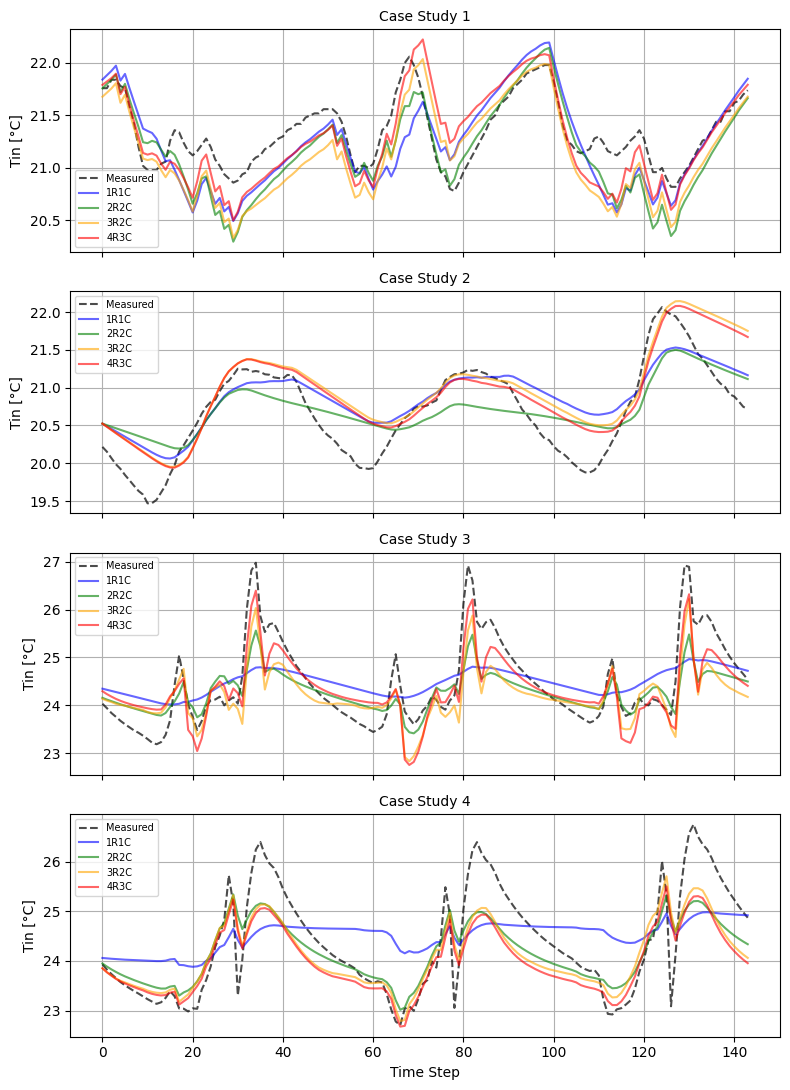

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# === Prepare data ===
datasets = [train_cs1, train_cs2, train_cs3, train_cs4]
labels = ['Case Study 1', 'Case Study 2', 'Case Study 3', 'Case Study 4']
colors = ['blue', 'green', 'orange', 'red']
model_sets = [
    [val_pred_1r1c_cs1, val_pred_2r2c_cs1, val_pred_3r2c_cs1, val_pred_4r3c_cs1],
    [val_pred_1r1c_cs2, val_pred_2r2c_cs2, val_pred_3r2c_cs2, val_pred_4r3c_cs2],
    [val_pred_1r1c_cs3, val_pred_2r2c_cs3, val_pred_3r2c_cs3, val_pred_4r3c_cs3],
    [val_pred_1r1c_cs4, val_pred_2r2c_cs4, val_pred_3r2c_cs4, val_pred_4r3c_cs4],
]
model_names = ['1R1C', '2R2C', '3R2C', '4R3C']

# === Create subplots ===
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8, 11), sharex=True)

for i, (ax, models, label) in enumerate(zip(axes, model_sets, labels)):
    N = len(models[i])
    x = np.arange(N)
    T_true = models[i]["INDOOR_TEMP"]


    ax.plot(x, T_true, linestyle='--', color='black', alpha=0.7, label='Measured')

    for model, color, name in zip(models, colors, model_names):
        T_model = np.array(model['T_in_estimate'])  
        ax.plot(x, T_model[:N], label=name, color=color, alpha=0.6) 
        print (f"RMSE {name} {label}: {np.sqrt(mean_squared_error(model['INDOOR_TEMP'], model['T_in_estimate'])):.2f} °C")
    ax.set_ylabel("Tin [°C]")
    ax.set_title(label, fontsize=10)
    ax.grid(True)
    ax.legend(fontsize=7)

axes[-1].set_xlabel("Time Step")
plt.tight_layout()
plt.show()


In [10]:
# import matplotlib.pyplot as plt
# import numpy as np

# # === Prepare data ===
# datasets = [train_cs1, train_cs2, train_cs3, train_cs4]
# labels = ['Case Study 1', 'Case Study 2', 'Case Study 3', 'Case Study 4']
# colors = ['blue', 'green', 'orange', 'red']
# model_sets = [
#     [test_pred_1r1c_cs1, test_pred_2r2c_cs1, test_pred_3r2c_cs1, test_pred_4r3c_cs1],
#     [test_pred_1r1c_cs2, test_pred_2r2c_cs2, test_pred_3r2c_cs2, test_pred_4r3c_cs2],
#     [test_pred_1r1c_cs3, test_pred_2r2c_cs3, test_pred_3r2c_cs3, test_pred_4r3c_cs3],
#     [test_pred_1r1c_cs4, test_pred_2r2c_cs4, test_pred_3r2c_cs4, test_pred_4r3c_cs4],
# ]
# model_names = ['1R1C', '2R2C', '3R2C', '4R3C']

# # === Create subplots ===
# fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8, 11), sharex=True)

# for i, (ax, models, label) in enumerate(zip(axes, model_sets, labels)):
#     N = len(models[i])
#     x = np.arange(N)
#     T_true = models[i]["INDOOR_TEMP"]


#     ax.plot(x, T_true, linestyle='--', color='black', alpha=0.7, label='Measured')

#     for model, color, name in zip(models, colors, model_names):
#         T_model = np.array(model['T_in_estimate'])  
#         ax.plot(x, T_model[:N], label=name, color=color, alpha=0.6) 

#     ax.set_ylabel("Tin [°C]")
#     ax.set_title(label, fontsize=10)
#     ax.grid(True)
#     ax.legend(fontsize=7)

# axes[-1].set_xlabel("Time Step")
# plt.tight_layout()
# plt.show()


## Computantional Time ##

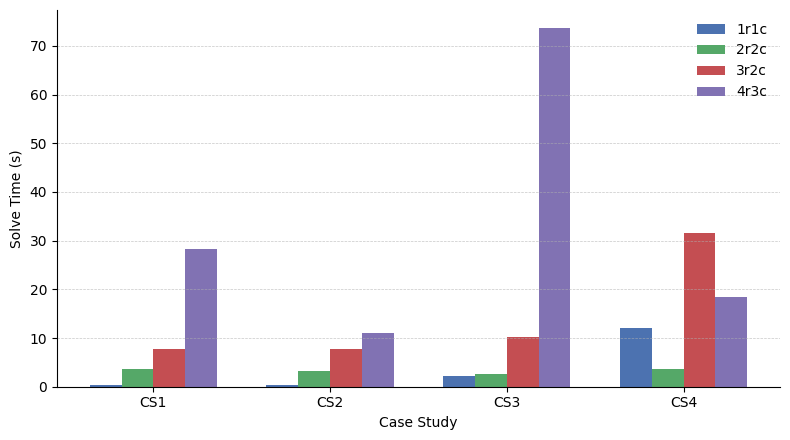

In [22]:
cases = ['CS1', 'CS2', 'CS3', 'CS4']
models = ['1r1c', '2r2c', '3r2c', '4r3c']
solve_times = {
    '1r1c': [solve_time_1r1c_cs1, solve_time_1r1c_cs2, solve_time_1r1c_cs3, solve_time_1r1c_cs4],
    '2r2c': [solve_time_2r2c_cs1, solve_time_2r2c_cs2, solve_time_2r2c_cs3, solve_time_2r2c_cs4],
    '3r2c': [solve_time_3r2c_cs1, solve_time_3r2c_cs2, solve_time_3r2c_cs3, solve_time_3r2c_cs4],
    '4r3c': [solve_time_4r3c_cs1, solve_time_4r3c_cs2, solve_time_4r3c_cs3, solve_time_4r3c_cs4],
}

# Bar plot settings
x = np.arange(len(cases))
width = 0.18
colors = ['#4c72b0', '#55a868', '#c44e52', '#8172b3']

fig, ax = plt.subplots(figsize=(8, 4.5))

for i, model in enumerate(models):
    ax.bar(x + i * width, solve_times[model], width, label=model, color=colors[i])

# Axis formatting
ax.set_xticks(x + 1.5 * width)
ax.set_xticklabels(cases)
ax.set_ylabel("Solve Time (s)")
ax.set_xlabel("Case Study")
# ax.set_title("Comparison of Solve Time Across Models and Case Studies", fontsize=13, pad=10)

# Style
ax.legend(frameon=False)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, axis='y')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()